In [55]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

from assimilation import ExtendedKF, OI, EnKF, M3DVar

In [2]:
def lorenz96_fdm(x0, ts, F=8):
    dt = ts[1] - ts[0]
    x = np.zeros((x0.size, ts.size))
    x[:,0] = x0.ravel()
    
    for idx, time in enumerate(ts[1:]):
        xn = x[:,idx]
        xn_p1 = np.roll(xn, -1)  # x_{n+1}
        xn_m1 = np.roll(xn, 1)  # x_{n-1}
        xn_m2 = np.roll(xn, 2)  # x_{n-2}
        x[:,idx+1] = xn + dt * ((xn_p1-xn_m2) * xn_m1 - xn + F)
        
    return x

def gen_random_obserr(mean, var, size, obs_intv, random_state=None):
    """
    Generate random gaussian observation error.
    
    Parameters:
    ----------
    mean, var: scaler.
        Mean and variance for gaussian distribution.
    size: int.
        The size of output array.
    obs_intv: int.
        The observation interval length in the output array.
    random_state: int.
        Random state. Default is None and it will use np.random.randint.
        
    Return:
    ------
    obs_err: 1-d array.
        The array which observation error occurs every `obs_intv` and others are 0.
        
    EX:
    >>> gen_random_obserr(0, 1, 12, 4)
    array([-0.34889445,  0,  0,  0,  0.98370343,  0,  0,  0,
           0.58092283,  0,  0,  0])
    """
    if random_state is None:
        random_state = np.random.randint(0, 50)
    
    length = np.ceil(size/obs_intv) * obs_intv
    obs_err = np.zeros(int(length)).reshape((-1,obs_intv))
    
    rng = np.random.RandomState(random_state)
    obs_err[:,0] = rng.normal(mean, np.sqrt(var), size=obs_err.shape[0])
    obs_err = obs_err.ravel()[:size]
    return obs_err

### Create natrue run

In [3]:
ndim = 40

F = 8
spn_time = 100
dt = 0.01
spn_ts = np.arange(0, spn_time, dt)

# spin up and get the initial condition for nature run
x0 = 0.1 * np.random.randn(ndim)
x_forecast = lorenz96_fdm(x0, spn_ts, F)
X_nature_ini = x_forecast[:,[-1]]

# create nature run
time = 16
ts = np.arange(0, time, dt)
X_nature = lorenz96_fdm(X_nature_ini, ts, F)
X_nature.shape

(40, 1600)

### Create initial condition

In [4]:
# spin up and use the last one as initial condition for experiments
spn_time = 100
spn_ts = np.arange(0, spn_time, dt)
x0 = 0.1 * np.random.randn(ndim)
x_forecast = lorenz96_fdm(x0, spn_ts, F)
X_ini = x_forecast[:,[-1]]
X_ini.shape

(40, 1)

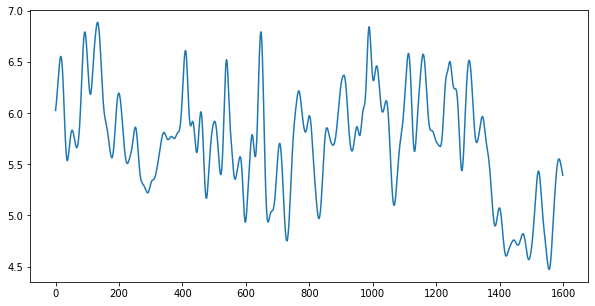

In [5]:
# noDA
time = 16
ts = np.arange(0, time, dt)
X_forecast = lorenz96_fdm(X_ini, ts, F)
rmse = np.sqrt(np.mean((X_forecast-X_nature)**2, axis=0))

plt.figure(figsize=(10, 5))
plt.plot(rmse);

### Create ensemble initial condition

In [20]:
N_ens = 30
X_ens_ini = np.random.multivariate_normal(X_ini.ravel(), Pb, size=N_ens).T  # (ndim, N_ens)

### Pb, R

In [11]:
Pb = np.load('lorenz96_Pb.npy')

obs_var = [2 for _ in range(ndim)]
R = np.eye(ndim)
np.fill_diagonal(R, obs_var)

### Assimilation normal distribution observation

In [26]:
# create observation
obs_mean = [0 for _ in range(ndim)]
obs_var = [2 for _ in range(ndim)]

# assimilate observation parameters
obs_timeintv = 0.08
obs_intv = int(obs_timeintv / dt)
cycle_num = int(time / obs_timeintv)

# construct observation error
size = int(time/dt)
X_obs_err = np.zeros((ndim, size))
for irow, (obsm, obsv) in enumerate(zip(obs_mean, obs_var)):
    X_obs_err[irow,:] = gen_random_obserr(obsm, obsv, size, obs_intv)
    
X_obs = X_nature + X_obs_err
X_obs = X_obs[:,::obs_intv]

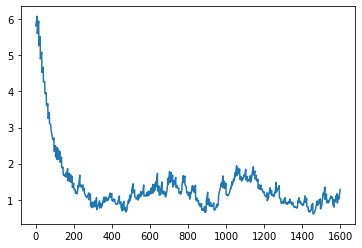

In [42]:
enkf_params = {
    'X_ens_ini': X_ens_ini, 
    'obs': X_obs, 
    'obs_interv': 8, 
    'R': R, 
    'H_func': None, 
    'alpha': 0.3,
    'inflat': 1.4
}

enkf = EnKF(lorenz96_fdm, dt)
enkf.set_params(**enkf_params)
enkf.cycle()
enkf.analysis
ens_mean = enkf.analysis.mean(axis=0)

rmse_enkf_normal = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
plt.plot(rmse_enkf_normal);

In [43]:
print(rmse_enkf_normal.mean())

1.3689116307559661


# Third Moment

### create skew observations

In [44]:
from scipy.stats import skewnorm


def tskew(alpha):
    """給定alpha, 計算理論的偏度值"""
    d = alpha / np.sqrt(1+alpha**2)
    return (4-np.pi)/2 * (d*np.sqrt(2/np.pi)) ** 3 / (1-2*d**2/np.pi) ** (3/2)

def gen_skewnormal(mean, var, alpha, size, random_state=None):
    # generate standard skew normal distribution
    X = skewnorm.rvs(alpha, loc=0, scale=1, size=size, random_state=random_state)
    
    # theory expectation value (mean) and variance of standard skew normal distribution
    tmean = np.sqrt(2/np.pi) * alpha / np.sqrt(1+alpha**2)
    tvar = 1 - 2/np.pi * alpha**2 / (1+alpha**2)

    # (1)adjust var (2)adjust mean. Order can not reverse
    X = np.sqrt(var/tvar) * X
    tmean = np.sqrt(var/tvar) * np.sqrt(2/np.pi) * alpha / np.sqrt(1+alpha**2)
    X = X + mean - tmean
    
    return X

In [45]:
ex_obs_dict = {}
ex_alpha = [0.15, 0.45, 0.75, 1.05, 1.35]

for ex_a in ex_alpha:
    obs_mean = [0 for _ in range(ndim)]
    obs_var = [2 for _ in range(ndim)]
    
    obs_timeintv = 0.08
    obs_intv = int(obs_timeintv / dt)
    cycle_num = int(time / obs_timeintv)
    
    size = int(time/dt)
    X_obs_err = np.zeros((ndim, size))
    for irow, (obsm, obsv) in enumerate(zip(obs_mean, obs_var)):
        # generate observations
        skew_obs = gen_skewnormal(obsm, obsv, ex_a, size)
        
        # set observations as 0 if it is not at the time of assimilation
        skew_obs_c = skew_obs.copy()
        skew_obs_c[::obs_intv] = 0
        skew_obs = skew_obs - skew_obs_c
        X_obs_err[irow,:] = skew_obs

    ex_obs = X_nature + X_obs_err
    ex_obs = ex_obs[:,::obs_intv]
    
    key = f'{ex_a:4.2f}'
    ex_obs_dict[key] = ex_obs

### assimilation skew observation

alpha=0.15, Mean RMSE=1.6877, Variance RMSE=1.0637,  Without spinup: Mean RMSE=1.5778, Variance RMSE=0.7020
alpha=0.45, Mean RMSE=1.3093, Variance RMSE=0.4573,  Without spinup: Mean RMSE=1.2169, Variance RMSE=0.1687
alpha=0.75, Mean RMSE=1.5846, Variance RMSE=1.2144,  Without spinup: Mean RMSE=1.4543, Variance RMSE=0.7067
alpha=1.05, Mean RMSE=1.4794, Variance RMSE=0.7253,  Without spinup: Mean RMSE=1.3556, Variance RMSE=0.2493
alpha=1.35, Mean RMSE=1.9071, Variance RMSE=0.9113,  Without spinup: Mean RMSE=1.7977, Variance RMSE=0.5403


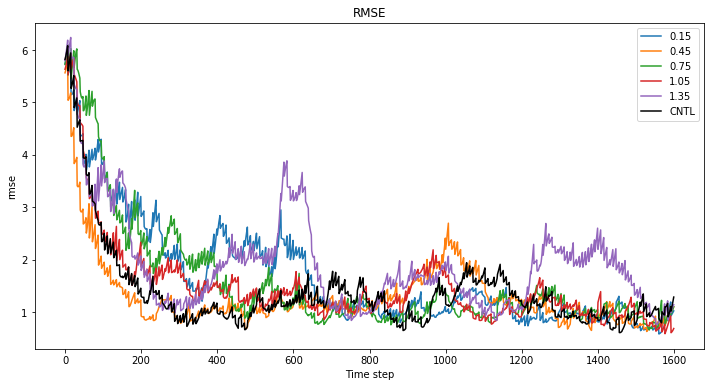

In [47]:
plt.figure(figsize=(12, 6))

for ex_a in ex_alpha:
    key = f'{ex_a:4.2f}'
    obs = ex_obs_dict[key]
    
    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz96_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    enkf.analysis
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse_enkf = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
    print(
        f'alpha={ex_a:.2f}, Mean RMSE={rmse_enkf.mean():.4f}, Variance RMSE={rmse_enkf.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse_enkf[50:].mean():.4f}, Variance RMSE={rmse_enkf[50:].var():.4f}'
    )

    plt.plot(rmse_enkf, label=key)
    
plt.plot(rmse_enkf_normal, 'k', label='CNTL')
plt.legend()
plt.title('RMSE')
plt.xlabel('Time step')
plt.ylabel('rmse');

### Create more extreme alpha and assimilation again

In [48]:
ex_obs_dict = {}
ex_alpha = [1.3, 1.55, 1.8, 2.05, 2.3, 2.55, 2.8, 3.05, 3.3]

for ex_a in ex_alpha:
    obs_mean = [0 for _ in range(ndim)]
    obs_var = [2 for _ in range(ndim)]
    
    obs_timeintv = 0.08
    obs_intv = int(obs_timeintv / dt)
    cycle_num = int(time / obs_timeintv)
    
    size = int(time/dt)
    X_obs_err = np.zeros((ndim, size))
    for irow, (obsm, obsv) in enumerate(zip(obs_mean, obs_var)):
        # generate observations
        skew_obs = gen_skewnormal(obsm, obsv, ex_a, size)
        
        # set observations as 0 if it is not at the time of assimilation
        skew_obs_c = skew_obs.copy()
        skew_obs_c[::obs_intv] = 0
        skew_obs = skew_obs - skew_obs_c
        X_obs_err[irow,:] = skew_obs

    ex_obs = X_nature + X_obs_err
    ex_obs = ex_obs[:,::obs_intv]
    
    key = f'{ex_a:4.2f}'
    ex_obs_dict[key] = ex_obs

alpha=1.30, Mean RMSE=1.4110, Variance RMSE=0.7740,  Without spinup: Mean RMSE=1.2972, Variance RMSE=0.3670
alpha=1.55, Mean RMSE=1.5007, Variance RMSE=0.8027,  Without spinup: Mean RMSE=1.3802, Variance RMSE=0.3496
alpha=1.80, Mean RMSE=1.4316, Variance RMSE=0.6802,  Without spinup: Mean RMSE=1.3163, Variance RMSE=0.2479
alpha=2.05, Mean RMSE=1.3748, Variance RMSE=0.5478,  Without spinup: Mean RMSE=1.2834, Variance RMSE=0.2785
alpha=2.30, Mean RMSE=2.0434, Variance RMSE=1.4665,  Without spinup: Mean RMSE=1.9346, Variance RMSE=1.1281
alpha=2.55, Mean RMSE=1.3439, Variance RMSE=0.5453,  Without spinup: Mean RMSE=1.2308, Variance RMSE=0.1445
alpha=2.80, Mean RMSE=1.3621, Variance RMSE=0.8529,  Without spinup: Mean RMSE=1.2450, Variance RMSE=0.4359
alpha=3.05, Mean RMSE=1.7198, Variance RMSE=0.7501,  Without spinup: Mean RMSE=1.6144, Variance RMSE=0.4020
alpha=3.30, Mean RMSE=1.3698, Variance RMSE=0.6182,  Without spinup: Mean RMSE=1.2603, Variance RMSE=0.2373


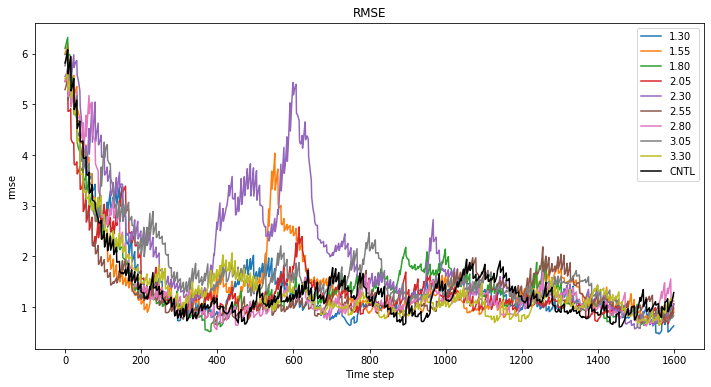

In [49]:
plt.figure(figsize=(12, 6))

for ex_a in ex_alpha:
    key = f'{ex_a:4.2f}'
    obs = ex_obs_dict[key]
    
    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz96_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    enkf.analysis
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse_enkf = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
    print(
        f'alpha={ex_a:.2f}, Mean RMSE={rmse_enkf.mean():.4f}, Variance RMSE={rmse_enkf.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse_enkf[50:].mean():.4f}, Variance RMSE={rmse_enkf[50:].var():.4f}'
    )

    plt.plot(rmse_enkf, label=key)
    
plt.plot(rmse_enkf_normal, 'k', label='CNTL')
plt.legend()
plt.title('RMSE')
plt.xlabel('Time step')
plt.ylabel('rmse');

# Fourth Moment

In [76]:
from scipy.stats import kurtosis
from scipy.special import erf, erfinv

def invcdf(x, mean, var, epsilon, delta):
    """inverse CDF of sinh-arcsinh transform of normal distrubution"""
    return np.sinh(epsilon/delta + 1/delta * np.arcsinh(mean + np.sqrt(2*var) * erfinv(2*x-1)))

def gen_kurtosis_normal(size, mean, var, epsilon, delta):
    u = np.random.rand(size)
    samples = invcdf(u, mean, var, epsilon, delta)
    return samples

def est_tvar(delta, size=1000, times=1000):
    """estimate theory variance"""
    variances = np.zeros((times,))
    for i in range(times):
        u = np.random.rand(size)
        samples = invcdf(u, 0, 2, 0, delta)
        variances[i] = samples.var()
    return np.mean(variances)

### generate kurtosis observations and assimilate

In [78]:
ex_delta = [
    0.5, 0.6, 0.7, 0.8,    # reject H0 
    0.9, 1.2,              # accept H0
    1.6, 1.8, 2, 2.2       # reject H0
]

ex_obs_dict = {}

for ex_d in ex_delta:
    obs_mean = [0 for _ in range(ndim)]
    obs_var = [2 for _ in range(ndim)]
    
    obs_timeintv = 0.08
    obs_intv = int(obs_timeintv / dt)
    cycle_num = int(time / obs_timeintv)
    
    size = int(time/dt)
    X_obs_err = np.zeros((ndim, size))
    for irow, (obsm, obsv) in enumerate(zip(obs_mean, obs_var)):
        # generate observations
        kurt_obs = gen_kurtosis_normal(size, obsm, obsv, 0, ex_d)
        # adjust to given obs variance
        kurt_obs = kurt_obs * np.sqrt(obsv / est_tvar(ex_d))
        
        # set observations as 0 if it is not at the time of assimilation
        kurt_obs_c = kurt_obs.copy()
        kurt_obs_c[::obs_intv] = 0
        kurt_obs = kurt_obs - kurt_obs_c
        X_obs_err[irow,:] = kurt_obs

    ex_obs = X_nature + X_obs_err
    ex_obs = ex_obs[:,::obs_intv]
    
    key = f'{ex_d:.1f}'
    ex_obs_dict[key] = ex_obs

In [79]:
ex_obs_dict['0.5'].shape

(40, 200)

delta=0.50, Mean RMSE=1.3548, Variance RMSE=0.6297,  Without spinup: Mean RMSE=1.2464, Variance RMSE=0.2653
delta=0.60, Mean RMSE=1.4587, Variance RMSE=1.0638,  Without spinup: Mean RMSE=1.3257, Variance RMSE=0.5128
delta=0.70, Mean RMSE=1.4217, Variance RMSE=0.8369,  Without spinup: Mean RMSE=1.3099, Variance RMSE=0.4535
delta=0.80, Mean RMSE=1.4128, Variance RMSE=1.0306,  Without spinup: Mean RMSE=1.2671, Variance RMSE=0.3816
delta=0.90, Mean RMSE=1.4467, Variance RMSE=0.8569,  Without spinup: Mean RMSE=1.3287, Variance RMSE=0.4235
delta=1.20, Mean RMSE=1.4319, Variance RMSE=0.7663,  Without spinup: Mean RMSE=1.3245, Variance RMSE=0.4101
delta=1.60, Mean RMSE=1.5411, Variance RMSE=0.6476,  Without spinup: Mean RMSE=1.4281, Variance RMSE=0.2450
delta=1.80, Mean RMSE=1.4154, Variance RMSE=1.2461,  Without spinup: Mean RMSE=1.2850, Variance RMSE=0.7407
delta=2.00, Mean RMSE=1.3030, Variance RMSE=0.7272,  Without spinup: Mean RMSE=1.1754, Variance RMSE=0.2167
delta=2.20, Mean RMSE=1.6940

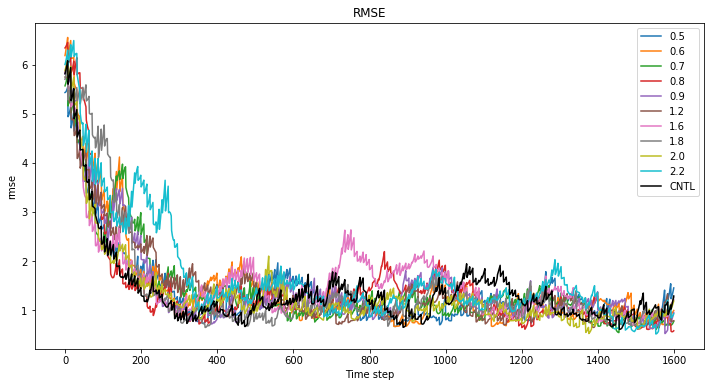

In [82]:
plt.figure(figsize=(12, 6))

for ex_d in ex_delta:
    key = f'{ex_d:.1f}'
    obs = ex_obs_dict[key]
    
    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz96_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    enkf.analysis
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse_enkf = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
    print(
        f'delta={ex_d:.2f}, Mean RMSE={rmse_enkf.mean():.4f}, Variance RMSE={rmse_enkf.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse_enkf[50:].mean():.4f}, Variance RMSE={rmse_enkf[50:].var():.4f}'
    )

    plt.plot(rmse_enkf, label=key)
    
plt.plot(rmse_enkf_normal, 'k', label='CNTL')
plt.legend()
plt.title('RMSE')
plt.xlabel('Time step')
plt.ylabel('rmse');

(-20, 20)

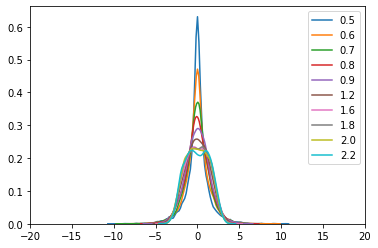

In [83]:
fig, ax = plt.subplots()

for key in ex_obs_dict.keys():
    obs = ex_obs_dict[key]
    obserr = obs - X_nature[:,::obs_intv]
    obserr = obserr.ravel()
    sns.kdeplot(obserr, label=key, ax=ax)
plt.xlim([-20, 20])

### test more extreme data

In [84]:
ex_delta = [0.1, 0.2, 0.3, 0.4, 2.5, 2.8, 3.1, 3.4]

ex_obs_dict = {}

for ex_d in ex_delta:
    obs_mean = [0 for _ in range(ndim)]
    obs_var = [2 for _ in range(ndim)]
    
    obs_timeintv = 0.08
    obs_intv = int(obs_timeintv / dt)
    cycle_num = int(time / obs_timeintv)
    
    size = int(time/dt)
    X_obs_err = np.zeros((ndim, size))
    for irow, (obsm, obsv) in enumerate(zip(obs_mean, obs_var)):
        # generate observations
        kurt_obs = gen_kurtosis_normal(size, obsm, obsv, 0, ex_d)
        # adjust to given obs variance
        kurt_obs = kurt_obs * np.sqrt(obsv / est_tvar(ex_d))
        
        # set observations as 0 if it is not at the time of assimilation
        kurt_obs_c = kurt_obs.copy()
        kurt_obs_c[::obs_intv] = 0
        kurt_obs = kurt_obs - kurt_obs_c
        X_obs_err[irow,:] = kurt_obs

    ex_obs = X_nature + X_obs_err
    ex_obs = ex_obs[:,::obs_intv]
    
    key = f'{ex_d:.1f}'
    ex_obs_dict[key] = ex_obs

delta=0.10, Mean RMSE=1.3283, Variance RMSE=1.2474,  Without spinup: Mean RMSE=1.1938, Variance RMSE=0.7059
delta=0.20, Mean RMSE=1.3430, Variance RMSE=0.9331,  Without spinup: Mean RMSE=1.2163, Variance RMSE=0.4351
delta=0.30, Mean RMSE=1.4043, Variance RMSE=0.8489,  Without spinup: Mean RMSE=1.2744, Variance RMSE=0.3297
delta=0.40, Mean RMSE=1.3740, Variance RMSE=0.6486,  Without spinup: Mean RMSE=1.2569, Variance RMSE=0.2100
delta=2.50, Mean RMSE=1.4392, Variance RMSE=0.9396,  Without spinup: Mean RMSE=1.3256, Variance RMSE=0.5542
delta=2.80, Mean RMSE=1.4418, Variance RMSE=0.9551,  Without spinup: Mean RMSE=1.3028, Variance RMSE=0.3594
delta=3.10, Mean RMSE=1.4726, Variance RMSE=1.0051,  Without spinup: Mean RMSE=1.3499, Variance RMSE=0.5478
delta=3.40, Mean RMSE=1.4637, Variance RMSE=1.0082,  Without spinup: Mean RMSE=1.3483, Variance RMSE=0.6025


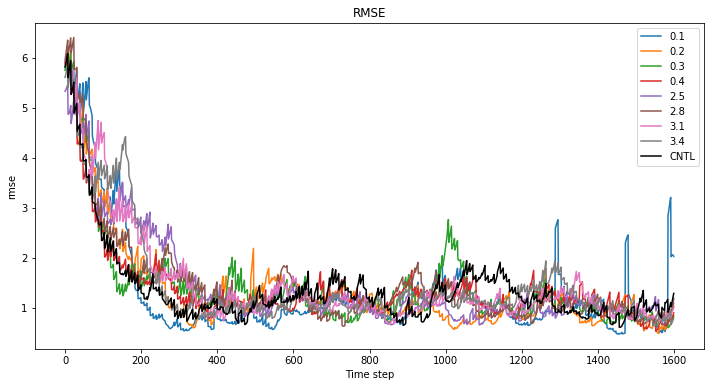

In [85]:
plt.figure(figsize=(12, 6))

for ex_d in ex_delta:
    key = f'{ex_d:.1f}'
    obs = ex_obs_dict[key]
    
    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz96_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    enkf.analysis
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse_enkf = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
    print(
        f'delta={ex_d:.2f}, Mean RMSE={rmse_enkf.mean():.4f}, Variance RMSE={rmse_enkf.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse_enkf[50:].mean():.4f}, Variance RMSE={rmse_enkf[50:].var():.4f}'
    )

    plt.plot(rmse_enkf, label=key)
    
plt.plot(rmse_enkf_normal, 'k', label='CNTL')
plt.legend()
plt.title('RMSE')
plt.xlabel('Time step')
plt.ylabel('rmse');

(0, 5)

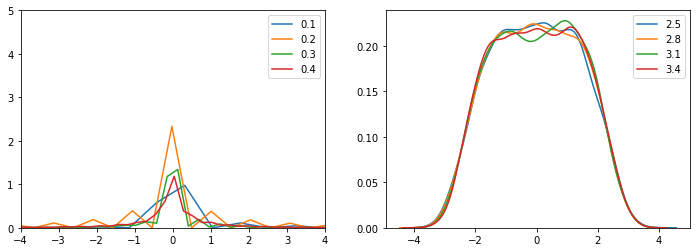

In [86]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

for key in ex_obs_dict.keys():
    if float(key) < 1:
        ax = axs[0]
    else:
        ax = axs[1]
    obs = ex_obs_dict[key]
    obserr = obs - X_nature[:,::obs_intv]
    obserr = obserr.ravel()
    sns.kdeplot(obserr, label=key, ax=ax)
axs[0].set_xlim([-4, 4])
axs[0].set_ylim([0, 5])